In [64]:
%matplotlib inline
import scipy
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

In [65]:
# acceleration due to gravity
g = 9.81

In [66]:
# equivalent pendulum length of the bell
l_b = 2

In [67]:
def deriv(y, t):
    [theta, vtheta] = y
    theta_dot  = vtheta
    vtheta_dot = - (g / l_b) * sin(theta)
    return [theta_dot, vtheta_dot]

In [89]:
# initial conditions
y0, t0 = [170 * np.pi / 180, 0], 0

In [110]:
# period of small oscillations
T0 = 2 * np.pi * np.sqrt(l_b / g)
print('Period of small oscillations: {:.4} seconds'.format(T0))

Period of small oscillations: 2.837 seconds


In [111]:
# Lima-Arun formula, from arXiv:physics/0510206v3
aa = np.cos(y0[0]/2)
Tlog = -T0 * np.log(aa) / (1 - aa)
print('Lima-Arun approximation for the period: {:.4} seconds'.format(Tlog))

Lima-Arun approximation for the period: 7.583 seconds


In [115]:
# Exact formula from elliptic integral
Texact = 4 * np.sqrt(l_b / g) * scipy.special.ellipk(np.sin(y0[0]/2)**2)
print('Exact period: {:.4} seconds'.format(Texact))

Exact period: 6.92 seconds


In [113]:
t = np.linspace(t0, Texact, 1000)
y = integrate.odeint(deriv, y0, t)

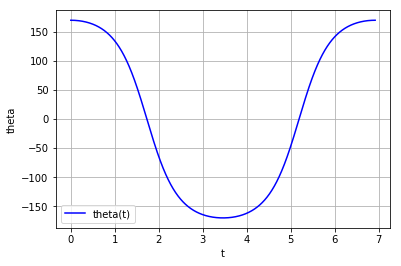

In [99]:
plt.plot(t, y[:,0] * 180 / np.pi, 'b', label='theta(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('theta')
plt.grid()
plt.show()